# 目標
- 小さなデータでsubmissionを目指す.

In [43]:
import sys
sys.path.append("../yandex/")
#sys.path.append("../lib/")
import os
import pandas as pd

import utils
import scoring

#import xgboost
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 100)

# データの準備

In [2]:
DATA_PATH = "../your_data_dir/"

In [3]:
train, test = utils.load_data_csv(
    DATA_PATH, utils.SIMPLE_FEATURE_COLUMNS)

/Users/m_nakao/.pyenv/versions/anaconda3-2.4.1/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## event数を絞る

In [4]:
sample = train.sample(100000)

In [5]:
sample.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  \
1533393      95       7      10       7   2.652632   1.000000   1.000000   
3026365     122      18      19      24   2.172131   2.333333   1.473684   
4396085      49       8       7       9   2.408163   1.125000   1.428572   
3175641      63      16       6      10   2.412698   1.750000   1.333333   
746523       84      13      15      19   3.119048   2.307692   1.066667   

         avg_cs[3]  ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
1533393   1.571428     8                   2                   2   
3026365   1.333333     8                   2                   2   
4396085   1.222222     8                   2                   2   
3175641   1.200000     8                   2                   2   
746523    1.105263     8                   2                   2   

         MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  \
1533393                   2                   2       -1682.9321   
3026365                   2                   2         446.3000   
4396085                   2                   2         484.5500   
3175641                   1                   1         237.8250   
746523                    2                   2        1493.1000   

         MatchedHit_X[1]  MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  \
1533393     -1844.450000      -2051.97000      -2192.67000        -65.08599   
3026365       426.260000        414.00000        443.72000       1318.52920   
4396085       577.510000        591.00000        884.72000       2387.72220   
3175641        43.751667       -261.13666       -591.80334       -532.35640   
746523       1639.060000       1804.60000       1929.82000       -563.95620   

         MatchedHit_Y[1]  MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  \
1533393       -70.730156        -75.59420        -78.92335        15201.865   
3026365      1422.382200       1526.20460       1629.81180        15208.748   
4396085      2575.974600       2764.19650       2952.10330        15212.598   
3175641      -360.157600       -462.59550       -529.27170        15118.082   
746523       -608.802200       -653.67883       -698.87060        15117.968   

         MatchedHit_Z[1]  MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  \
1533393        16406.045        17598.828        18806.916         12.948485   
3026365        16416.422        17610.395        18819.668         12.750000   
4396085        16420.576        17614.854        18824.430         25.500000   
3175641        16527.004        17798.436        18922.295          6.375000   
746523         16325.106        17518.545        18727.283         12.750000   

         MatchedHit_DX[1]  MatchedHit_DX[2]  MatchedHit_DX[3]  \
1533393         13.750000         59.000000         63.000000   
3026365         13.750000         59.000000         63.000000   
4396085         27.500000        118.000000        126.000000   
3175641          3.458333         14.833333         15.833333   
746523          13.750000         59.000000         63.000000   

         MatchedHit_DY[0]  MatchedHit_DY[1]  MatchedHit_DY[2]  \
1533393         63.038590         68.078926         73.078896   
3026365         63.078957         68.078926         73.078896   
4396085        126.278550        136.278490        146.278410   
3175641         31.479162         16.929256         18.179249   
746523          63.078957         68.078926         73.078896   

         MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  \
1533393          78.07886         33.727220          33.74537   
3026365          78.07886         33.727364          33.74537   
4396085         156.27835         33.954950          33.99096   
3175641          19.42924         33.613575          33.56118   
746523           78.07886         33.727364          33.74537   

         MatchedHit_DZ[2]  MatchedHit_DZ[3]  MatchedHit_T[0]  MatchedHit_T[1]  \
1533393         33.763374         33.781380      

## カラムを絞る
- とりあえず以下のものだけ抜き出す.
    - 評価用
        - label
        - weight
        - particle_type
    - 特徴量
        - PT
        - P
        - FOI_hits_N
        - ncl[0]
        - avg_cs[0]

In [6]:
selected = sample[['label', 'particle_type', 'weight', 'PT', 'P', 'FOI_hits_N', 'ncl[0]', 'avg_cs[0]']]

In [7]:
selected.head()

label  particle_type    weight           PT             P  \
1533393      1              1  2.163132  1104.134860  17651.915896   
3026365      1              1  1.723915  1562.194657  12197.701001   
4396085      1              1  2.213900  1306.320533   7141.197506   
3175641      1              1 -0.450841   846.502615   4484.930472   
746523       1              1  3.677911  1764.991850  24092.906628   

         FOI_hits_N  ncl[0]  avg_cs[0]  
1533393           4      95   2.652632  
3026365           7     122   2.172131  
4396085           5      49   2.408163  
3175641          20      63   2.412698  
746523            5      84   3.119048

## muonのeventを削る
- アンダーサンプリング

In [8]:
muons = len(selected[selected['particle_type']==1])
print("muons: "+ str(muons))
pions = len(selected[selected['particle_type']==0])
print("pions: "+ str(pions))
protons = len(selected[selected['particle_type']==2])
print("protons: "+ str(protons))

muons: 92260
pions: 4652
protons: 3088


In [9]:
# muon /(pion + proton)
#ratio = 0.5
number = 3000

In [10]:
#muon_under_sampled = selected.sample(muons_number)
pion_under_sampled = selected[selected['particle_type']==0].sample(number)
muon_under_sampled = selected[selected['particle_type']==1].sample(number)
proton_under_sampled = selected[selected['particle_type']==2].sample(number)

In [11]:
selected_under_sampled = pd.concat([muon_under_sampled, 
                                                                    proton_under_sampled, 
                                                                    pion_under_sampled])

In [12]:
muons = len(selected_under_sampled[selected_under_sampled['particle_type']==1])
print("muons: "+ str(muons))
pions = len(selected_under_sampled[selected_under_sampled['particle_type']==0])
print("pions: "+ str(pions))
protons = len(selected_under_sampled[selected_under_sampled['particle_type']==2])
print("protons: "+ str(protons))

muons: 3000
pions: 3000
protons: 3000


In [13]:
selected_under_sampled.describe()

label  particle_type       weight            PT              P  \
count  9000.000000    9000.000000  9000.000000   9000.000000    9000.000000   
mean      0.333333       1.000000    14.033263   2186.962809   30779.020351   
std       0.471431       0.816542    89.807314   2103.080814   42027.289252   
min       0.000000       0.000000 -2381.270034    800.089627    3018.838706   
25%       0.000000       0.000000     1.454729   1009.253939   10534.879034   
50%       0.000000       1.000000     2.805355   1347.599976   17971.934894   
75%       1.000000       2.000000    11.155273   2469.352605   33571.147922   
max       1.000000       2.000000  1452.786169  28841.910892  625982.810565   

        FOI_hits_N       ncl[0]    avg_cs[0]  
count  9000.000000  9000.000000  9000.000000  
mean      9.656333    63.050444     2.510755  
std       8.162752    33.928107     0.702776  
min       2.000000     2.000000     1.000000  
25%       5.000000    38.000000     2.032655  
50%       7.000000    57.000000     2.416667  
75%      11.000000    82.000000     2.872727  
max      97.000000   252.000000     7.915888

/Users/m_nakao/.pyenv/versions/anaconda3-2.4.1/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/m_nakao/.pyenv/versions/anaconda3-2.4.1/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/m_nakao/.pyenv/versions/anaconda3-2.4.1/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


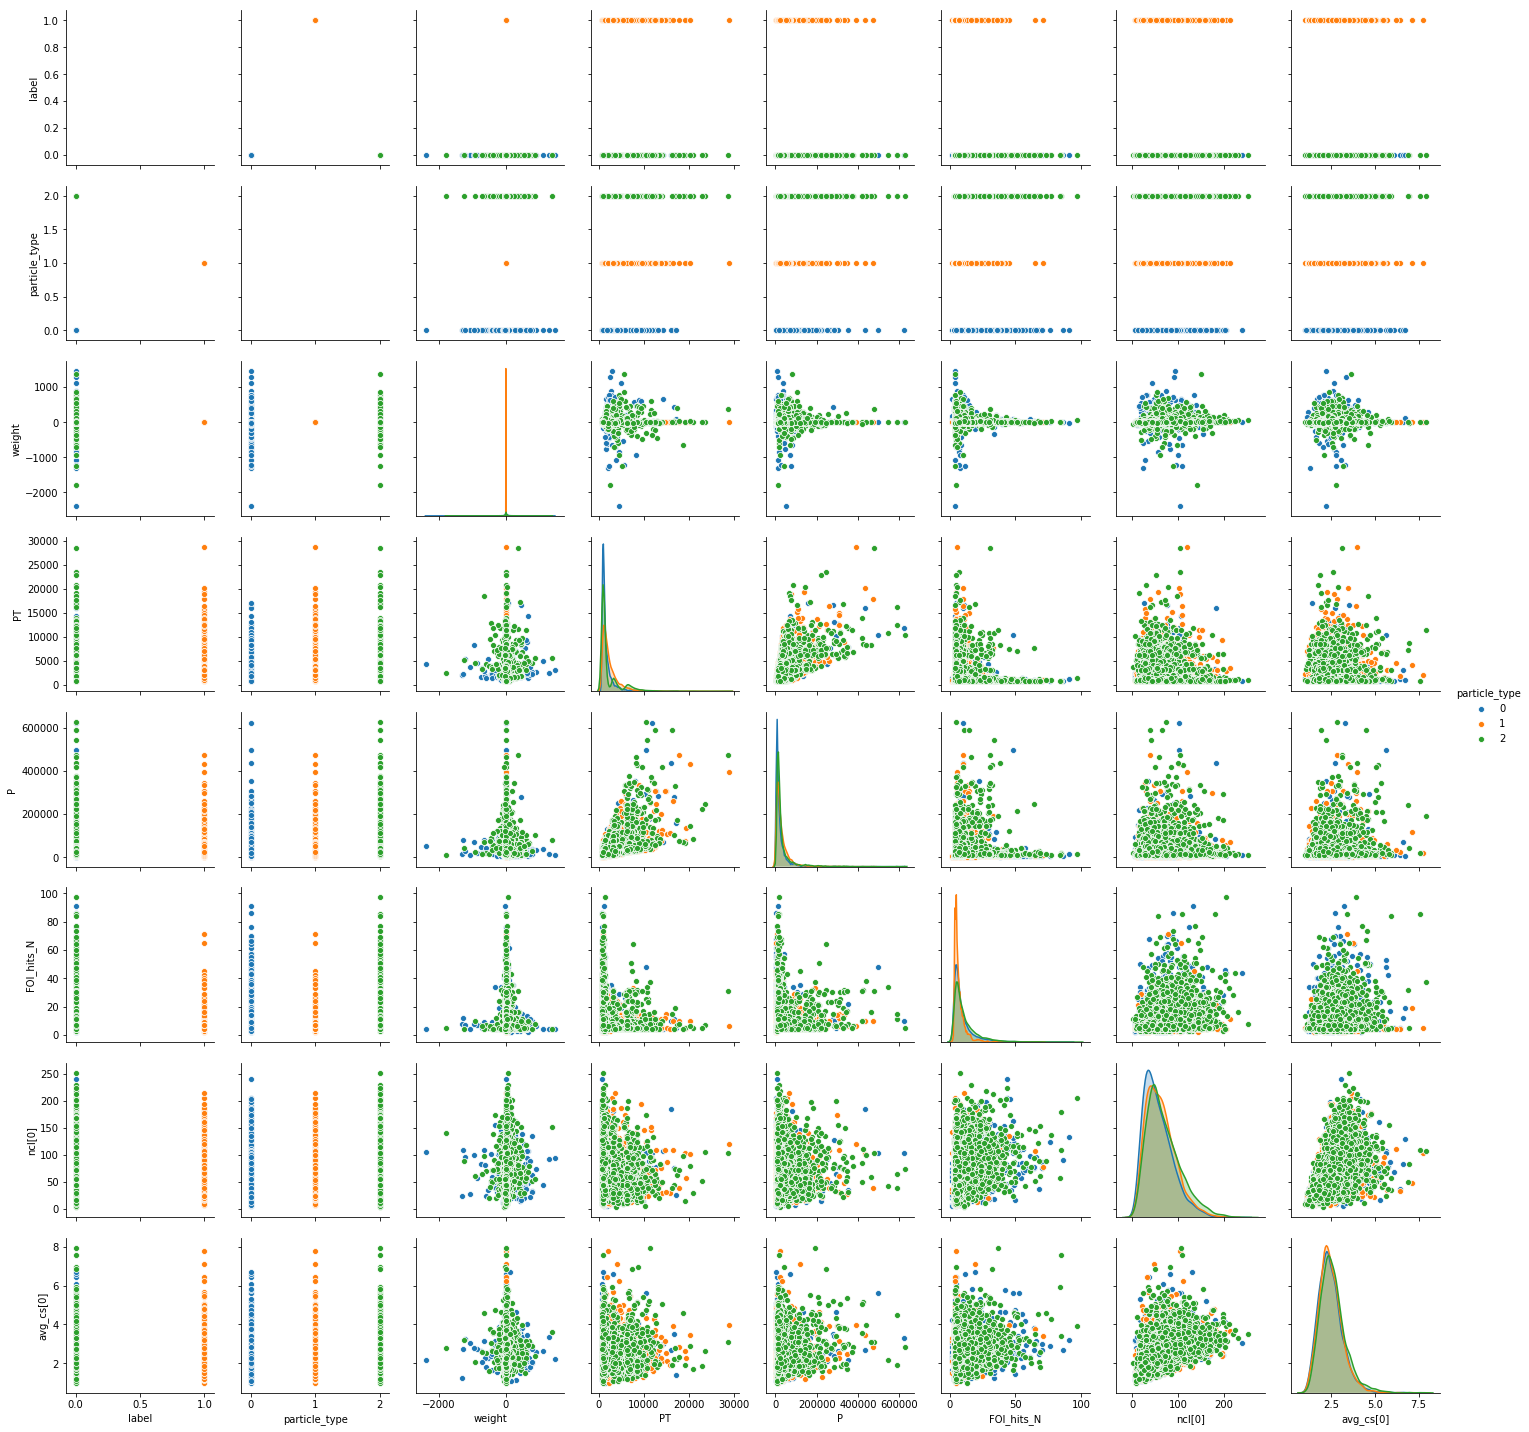

In [16]:
sns.pairplot(selected_under_sampled, hue='particle_type')

## train test split

In [17]:
splite_ratio = 0.3

In [18]:
X = selected_under_sampled[['PT', 'P', 'FOI_hits_N', 'ncl[0]', 'avg_cs[0]']]

In [19]:
y = selected_under_sampled['particle_type']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=splite_ratio, random_state=42)

In [21]:
X_train.head()

PT             P  FOI_hits_N  ncl[0]  avg_cs[0]
1175985  1271.553783  66684.104299          15      63   3.571429
2075512  1110.366427  12665.924367          31      95   2.694737
2808211  3399.893356  21186.477679           7      12   1.750000
4161815  3661.338289  15744.950738           5     109   2.403670
1020999  1158.360800  26933.700838          11      99   2.888889

In [22]:
y_train.head()

1175985    0
2075512    0
2808211    0
4161815    0
1020999    2
Name: particle_type, dtype: int64

In [23]:
y_train.describe()

count    6300.000000
mean        1.003651
std         0.817816
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: particle_type, dtype: float64

# 学習

In [24]:
model = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 5, verbose = 3)

In [25]:
model.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=3,
            warm_start=False)

### 学習結果の保存

In [76]:
#!mkdir ../models
#!ls

mkdir: ../models: File exists
data_check.ipynb          my_data_check.ipynb       submission
feature_engineering.ipynb my_sample_framework.ipynb
models                    sample_framework.ipynb


In [77]:
modelname = "RF_test"
modeldir="../models"

In [78]:
joblib.dump(model, modeldir + '/' + modelname + ".pkl")

['../models/RF_test.pkl']

# 評価

In [58]:
X_test.head()

PT             P  FOI_hits_N  ncl[0]  avg_cs[0]
4883630  3300.442384  26197.233674           5      79   2.784810
2915320  1461.902124   8310.324973          10      20   1.300000
3490380  2147.196240  12453.178092           4      88   3.318182
1958993  6947.692496  33805.936424           5      36   1.722222
3754396  3730.765194  29994.057208           7      30   2.300000

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


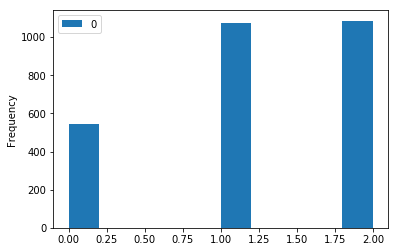

In [26]:
pd.DataFrame(model.predict(X_test)).plot.hist()

### 3クラス分類のスコア

In [27]:
accuracy_score(y_test, model.predict(X_test))

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.5518518518518518

- ランダムよりちょいいいくらい

### 各particle_typeの対する確率

In [28]:
pd.DataFrame(model.predict_proba(X_test))

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0         1         2
0     0.201949  0.496269  0.301782
1     0.557800  0.362896  0.079304
2     0.311702  0.551977  0.136321
3     0.160722  0.341333  0.497945
4     0.239179  0.463490  0.297331
5     0.699656  0.195770  0.104575
6     0.150413  0.438085  0.411502
7     0.198787  0.495494  0.305718
8     0.335389  0.474209  0.190403
9     0.322494  0.430227  0.247278
10    0.238162  0.262313  0.499526
11    0.327771  0.494590  0.177639
12    0.232279  0.104631  0.663089
13    0.226526  0.451238  0.322236
14    0.353861  0.401943  0.244196
15    0.211001  0.096667  0.692332
16    0.422851  0.403996  0.173153
17    0.400177  0.260742  0.339081
18    0.411775  0.432285  0.155940
19    0.329980  0.225916  0.444103
20    0.411217  0.439238  0.149545
21    0.223249  0.170141  0.606610
22    0.344965  0.219733  0.435302
23    0.341290  0.412044  0.246665
24    0.228428  0.493500  0.278073
25    0.233005  0.264090  0.502905
26    0.698097  0.229940  0.071963
27    0.334685  0.320895  0.344420
28    0.322000  0.427979  0.250021
29    0.237170  0.091241  0.671589
...        ...       ...       ...
2670  0.226495  0.087391  0.686114
2671  0.192480  0.491622  0.315898
2672  0.311620  0.202881  0.485499
2673  0.285420  0.170266  0.544314
2674  0.602627  0.333708  0.063665
2675  0.771120  0.173075  0.055805
2676  0.230381  0.218646  0.550973
2677  0.299301  0.557300  0.143399
2678  0.192532  0.095675  0.711793
2679  0.331443  0.498186  0.170372
2680  0.312079  0.546337  0.141584
2681  0.261278  0.306203  0.432520
2682  0.304429  0.215539  0.480032
2683  0.243086  0.245717  0.511197
2684  0.247012  0.453314  0.299674
2685  0.304715  0.175250  0.520035
2686  0.666971  0.247228  0.085802
2687  0.236095  0.421289  0.342616
2688  0.216004  0.455528  0.328468
2689  0.508073  0.403698  0.088228
2690  0.319067  0.498259  0.182674
2691  0.322333  0.476139  0.201528
2692  0.158074  0.310955  0.530970
2693  0.622150  0.302437  0.075414
2694  0.309403  0.550066  0.140531
2695  0.682420  0.261776  0.055804
2696  0.493659  0.380256  0.126084
2697  0.265050  0.455892  0.279058
2698  0.221881  0.449323  0.328797
2699  0.191475  0.076562  0.731963

[2700 rows x 3 columns]

## weightも考えたスコア

In [29]:
y_score = selected_under_sampled[['label', 'particle_type', 'weight']]

In [30]:
y_score.head()

label  particle_type    weight
293591       1              1  2.266836
2664173      1              1  3.572248
5141702      1              1  2.266930
2657836      1              1  4.273420
119865       1              1  3.212692

In [31]:
X_score_train, X_score_test, y_score_train, y_score_test = train_test_split(X, y_score, test_size=splite_ratio, random_state=42)



In [32]:
X_score_test.head()

PT             P  FOI_hits_N  ncl[0]  avg_cs[0]
4883630  3300.442384  26197.233674           5      79   2.784810
2915320  1461.902124   8310.324973          10      20   1.300000
3490380  2147.196240  12453.178092           4      88   3.318182
1958993  6947.692496  33805.936424           5      36   1.722222
3754396  3730.765194  29994.057208           7      30   2.300000

In [33]:
y_score_test.head()

label  particle_type     weight
4883630      0              0  12.634956
2915320      1              1   3.500064
3490380      1              1   2.112622
1958993      0              2  15.880784
3754396      0              0  13.519622

In [34]:
y_score_predict = model.predict_proba(X_score_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [35]:
y_score_predict

array([[0.2019494 , 0.49626873, 0.30178187],
       [0.55779998, 0.36289583, 0.07930419],
       [0.31170166, 0.55197745, 0.13632089],
       ...,
       [0.26505002, 0.45589165, 0.27905833],
       [0.2218806 , 0.44932251, 0.3287969 ],
       [0.19147547, 0.07656161, 0.73196291]])

In [36]:
predictions_score_predict = y_score_predict[:,1]

In [37]:
predictions_score_predict

array([0.49626873, 0.36289583, 0.55197745, ..., 0.45589165, 0.44932251,
       0.07656161])

In [38]:
weights_score_predict = y_score_test['weight'].values

In [39]:
weights_score_predict

array([12.63495594,  3.50006411,  2.11262185, ..., 14.70454814,
       32.83695699, 23.71961476])

In [40]:
labels_score_predict = y_score_test['label'].values

In [41]:
labels_score_predict

array([0, 1, 1, ..., 0, 0, 0])

In [42]:
scoring.rejection90(labels_score_predict, predictions_score_predict, weights_score_predict)

0.20798439704586907

### scoring.pyについて
- find_threshold_for_efficiency
-> a: prediction array, e: TPR(float), w: weight array, websiteでのthe final threshold value Θを計算する
- get_rejection_at_efficiency_raw
-> labels: array{0,1}, predictions: array[0,1], weights: array, quantile: float 基準, The metric equals to (1-FPR)の分子分母を出す
- get_rejection_at_efficiency
-> labels, predictions, threshold (上のquantile), sample_weight (上のweights)
- rejection90
-> 上の関数で、threshold = 0.9としたもの

# 予測
- testデータに対して

### 学習したモデルの読み込み

In [79]:
modelname = "RF_test"
modeldir="../models"

In [80]:
model_read = joblib.load(modeldir + '/' + modelname + ".pkl")

### testデータの方も前処理する
- 上の方で同時にやるのがいいな... 

In [54]:
test.describe()

ncl[0]         ncl[1]         ncl[2]         ncl[3]  \
count  726095.000000  726095.000000  726095.000000  726095.000000   
mean       62.811942      19.554897      12.448600      13.012038   
std        32.264048      12.681014       7.451726       6.375977   
min         2.000000       0.000000       0.000000       0.000000   
25%        39.000000      10.000000       7.000000       8.000000   
50%        58.000000      17.000000      11.000000      12.000000   
75%        82.000000      26.000000      16.000000      16.000000   
max       285.000000     196.000000      84.000000      81.000000   

           avg_cs[0]      avg_cs[1]      avg_cs[2]      avg_cs[3]  \
count  726095.000000  726095.000000  726095.000000  726095.000000   
mean        2.466626       2.118251       1.447288       1.359854   
std         0.657863       0.778726       0.368397       0.430181   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.012987       1.571428       1.185185       1.125000   
50%         2.386792       2.000000       1.388889       1.285714   
75%         2.822581       2.500000       1.636364       1.500000   
max        10.904762      25.666666       9.571428      16.500000   

                ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
count  726095.000000       726095.000000       726095.000000   
mean        7.931243            1.962469            1.964324   
std         0.400455            0.190059            0.185481   
min         4.000000            1.000000            1.000000   
25%         8.000000            2.000000            2.000000   
50%         8.000000            2.000000            2.000000   
75%         8.000000            2.000000            2.000000   
max         8.000000            2.000000            2.000000   

       MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  \
count       726095.000000       726095.000000    726095.000000   
mean             1.800077            1.788570        -0.265976   
std              0.439050            0.450192      1547.473481   
min              0.000000            0.000000     -4862.180000   
25%              2.000000            2.000000      -815.455000   
50%              2.000000            2.000000         7.558333   
75%              2.000000            2.000000       813.075000   
max              2.000000            2.000000      4832.950000   

       MatchedHit_X[1]  MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  \
count    726095.000000    726095.000000    726095.000000    726095.000000   
mean         -0.494001      -164.333201      -183.128382        -4.334283   
std        1690.196022      2218.311490      2344.461028      1346.489794   
min       -5243.800000     -9999.000000     -9999.000000     -3951.223600   
25%        -884.325000     -1042.870000     -1114.070000      -793.841700   
50%           8.068334       -37.870000       -41.370000       -32.562122   
75%         883.185000       918.600000       982.220000       783.449400   
max        5209.310000      5557.000000      5933.120000      3898.132300   

       MatchedHit_Y[1]  MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  \
count    726095.000000    726095.000000    726095.000000    726095.000000   
mean         -5.034248      -168.809096      -183.127655     15261.422972   
std        1450.342314      1990.991526      2090.162551       108.476325   
min       -4259.906700     -9999.000000     -9999.000000     15105.030000   
25%        -857.026370      -958.983150     -1023.974800     15190.861000   
50%         -35.208393       -74.082610       -78.923350     15257.947000   
75%         844.163940       902.111100       932.315700     15332.404000   
max        4205.364300      4512.695300      4820.811000     15418.309000   

       MatchedHit_Z[1]  MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  \
count    726095.000000    726095.000000    726095.000000     726095.000000   
mean      16467.135053     17206.558442     18349.6402

#### 今回予測に使うものだけ抜き出す

In [56]:
test_selected = test[['PT', 'P', 'FOI_hits_N', 'ncl[0]', 'avg_cs[0]']]

In [57]:
test_selected.head()

PT             P  FOI_hits_N  ncl[0]  avg_cs[0]
id                                                          
0   1174.484530   6884.502272           6      55   2.127273
1   4344.639775  48769.526891           7      43   2.697674
2   4109.805750  20296.048412           4      90   1.800000
3    940.242439  26062.046122           9     141   4.609929
4   1386.377851  59872.343332           8      22   1.636364

### 予測の実行

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.8s finished


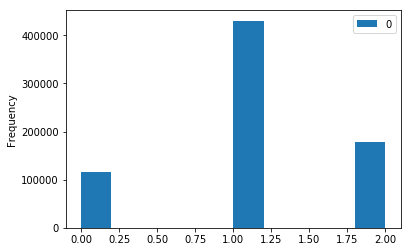

In [59]:
pd.DataFrame(model_read.predict(test_selected)).plot.hist()

In [81]:
predictions = model_read.predict_proba(test_selected)[:,1]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished


# 提出

In [74]:
#!mkdir ../submission
#!ls ../

README.md     models        ref           yandex
env           notebook      submission    your_data_dir


In [84]:
submissionname = "test20190120"
submissiondir = "../submission"

In [85]:
pd.DataFrame(data={"prediction":predictions}, index=test_selected.index).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=utils.ID_COLUMN)